In [ ]:

import pandas as pd
import subprocess, os
from tempfile import NamedTemporaryFile

# --- MixMHCpred 9-mer peptide binder prediction script ---

# This script takes a CSV file of subpeptides (generated by Yugendran/Jun's scripts), filters for 9-mers,
# runs MixMHCpred for specified HLA alleles, and outputs results
# with affinity scores and sample metadata.

# Code written using https://github.com/GfellerLab/MixMHCpred as the basis of the script

# Author: adyant 

CSV_PATH    = "/Users/adyant/Documents/Stanford/Coterm/BIOMEDIN 212/Final_Project/common_subpeptides.csv"
ALLELES     = ["HLA-A02:01", "HLA-B07:02"]
OUTPUT_ALL     = "mixmhcpred_all_9mers.csv"
OUTPUT_STRONG  = "mixmhcpred_strong_9mers.csv"
IC50_CUTOFF = 500
MHC_PRED    = "/Users/adyant/MixMHCpred/MixMHCpred"  


df = pd.read_csv(CSV_PATH)
df_9mer = df[df["subpeptide"].str.len() == 9].copy()
peptides_9mer = df_9mer["subpeptide"].tolist()

# --- Check for valid input ---
with NamedTemporaryFile(mode="w+", delete=False) as tmp:
    tmp.write("\n".join(peptides_9mer))
    tmp_path = tmp.name


codes       = [a.replace("HLA-", "").replace("*", "").replace(":", "") for a in ALLELES]
alleles_arg = ",".join(codes)

# Calling MixMHCpred once for all alleles
out_tmp = "mixmhcpred_9mers_output.txt"
proc = subprocess.run(
    [MHC_PRED, "-i", tmp_path, "-o", out_tmp, "-a", alleles_arg],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE,
    universal_newlines=True
)
os.remove(tmp_path)
if proc.returncode != 0:
    print("MixMHCpred error:", proc.stderr.strip())
    raise RuntimeError("MixMHCpred failed")


with open(out_tmp) as f:
    lines = [l.strip() for l in f if not l.startswith("#") and l.strip()]
if not lines:
    raise RuntimeError("No data in MixMHCpred output")
header = lines[0].split()
data   = [l.split() for l in lines[1:]]
df_out = pd.DataFrame(data, columns=header)


pep_col           = header[0]                                
allele_score_cols = [c for c in header if c.startswith("Score_") and c != "Score_bestAllele"]


melted = df_out.melt(
    id_vars=[pep_col],
    value_vars=allele_score_cols,
    var_name="code",
    value_name="affinity"
)


melted["allele_code"] = melted["code"].str.replace("^Score_", "", regex=True)
code_to_hla = {
    allele_code: full for allele_code, full in zip(codes, ALLELES)
}
melted["allele"] = melted["allele_code"].map(code_to_hla)


melted.rename(columns={pep_col: "peptide"}, inplace=True)
melted["affinity"] = melted["affinity"].astype(float)


melted["sample_count"] = melted["peptide"].map(df_9mer.set_index("subpeptide")["sample_count"])
melted["samples"]      = melted["peptide"].map(df_9mer.set_index("subpeptide")["samples"])

melted.to_csv(OUTPUT_ALL, index=False)
melted.query("affinity <= @IC50_CUTOFF").to_csv(OUTPUT_STRONG, index=False)


print(f" All predictions are in {OUTPUT_ALL}")
print(f" Strong binders are in {OUTPUT_STRONG}")

# Converting affinity scores to IC50 values (nM)
melted["ic50_nM"] = 10 ** (-melted["affinity"])


melted.to_csv(OUTPUT_ALL, index=False)


# Filter for strong binders by IC50 cutoff
strong_ic50 = melted[melted["ic50_nM"] <= IC50_CUTOFF].copy()
strong_ic50.to_csv(OUTPUT_STRONG, index=False)
print("Strong binders by IC50:", strong_ic50.shape[0])


rank_cols = [c for c in df_out.columns if c.startswith("%Rank_") and c not in ("%Rank_bestAllele",)]
melted_rank = df_out.melt(id_vars=["Peptide"], value_vars=rank_cols,
                          var_name="code", value_name="percentile")

melted_rank["allele_code"] = melted_rank["code"].str.replace("%Rank_", "", regex=True)
melted_rank["allele"] = melted_rank["allele_code"].map(code_to_hla)
melted_rank.rename(columns={"Peptide":"peptide"}, inplace=True)
melted_rank["percentile"] = melted_rank["percentile"].astype(float)


strong_rank = melted_rank[melted_rank["percentile"] <= 2.0].copy()
strong_rank.to_csv("mixmhcpred_strong_by_rank.csv", index=False)
print("Strong binders by %Rank ≤2%:", strong_rank.shape[0])

 All predictions are in mixmhcpred_all_9mers.csv
 Strong binders are in mixmhcpred_strong_9mers.csv
Strong binders by IC50: 464
Strong binders by %Rank ≤2%: 65


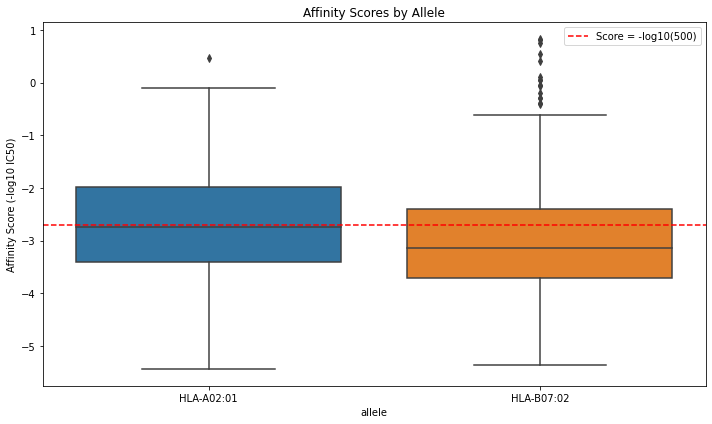

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Visualize the affinity scores for all alleles
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x="allele", y="affinity")
plt.axhline(-np.log10(IC50_CUTOFF), color='red', linestyle='--', label=f'Score = -log10({IC50_CUTOFF})')
plt.ylabel("Affinity Score (-log10 IC50)")
plt.title("Affinity Scores by Allele")
plt.legend()
plt.tight_layout()
plt.show()


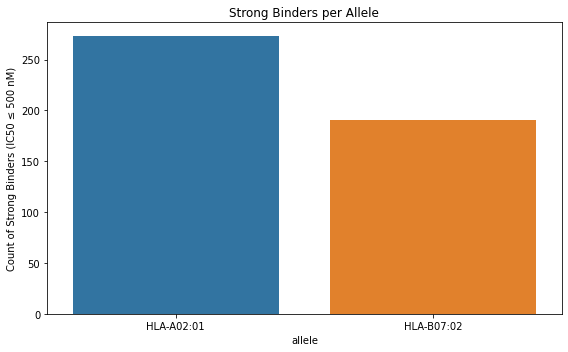

In [ ]:
# --- Visualization ---
# For visualization, we will plot the affinity scores for all alleles
plt.figure(figsize=(8, 5))
sns.countplot(data=strong_ic50, x="allele")
plt.ylabel("Count of Strong Binders (IC50 ≤ 500 nM)")
plt.title("Strong Binders per Allele")
plt.tight_layout()
plt.show()
